### Fully Bayesian Unfolding for Raw Matrix

In [3]:
import ompy as om 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

<IPython.core.display.Javascript object>


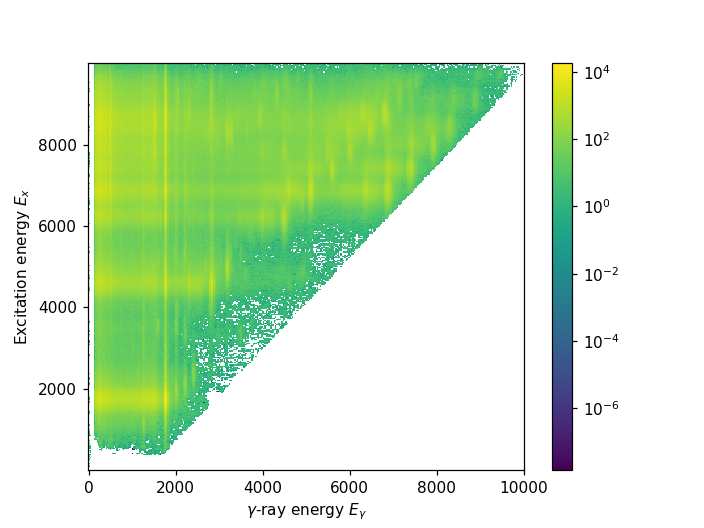

333
322


In [12]:
%matplotlib notebook

# Reading the dat
raw = om.Matrix(path="/home/vala/Downloads/h_Ex_Eg_improved_bgsubtr_noneg_28Si.m")


#Setting every count below this diagonal to zero
raw.cut_diagonal(E1=(1800, 500), E2=(10500, 10000))

#Cutting the matrix itself
raw.cut('Ex', 0, 10000)
raw.cut('Eg', 0, 10000)

#Rebinning for faster computation time 
raw.rebin(axis= "Eg", factor=6)
raw.rebin(axis= "Ex", factor=1)


raw.plot()

Ex = raw.Ex
Eg = raw.Eg

raw_py, E = raw.projection(axis="Eg", Emin=4400, Emax=4800)
print(len(Eg))
print(len(Ex))

<IPython.core.display.Javascript object>


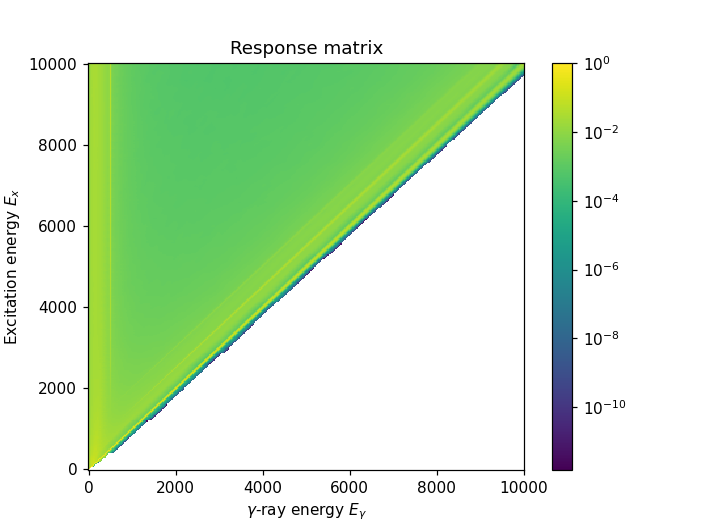

(<matplotlib.collections.QuadMesh at 0x7fb6b40eff50>,
 <Figure size 640x480 with 2 Axes>)

In [6]:
# Initiating the response matrix for the Iterative Unfolding OMpy

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

folderpath = "/home/vala/Documents/Master/MachineLearning/ompy/OCL_response_functions/oscar2017_scale1.15"
response = om.Response(folderpath)

R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)

# Magne recommends 1/10 of the actual resolution for unfolding purposes
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)

R_ompy_view.plot(title="Response matrix", scale='log')

In [7]:
#Unfolding the whole raw matrix
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.response_tab = R_tab_view 
unfolder.use_compton_subtraction = True 
unfolder.num_iter = 500

unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded_OMpy = unfolder(raw)

<IPython.core.display.Javascript object>


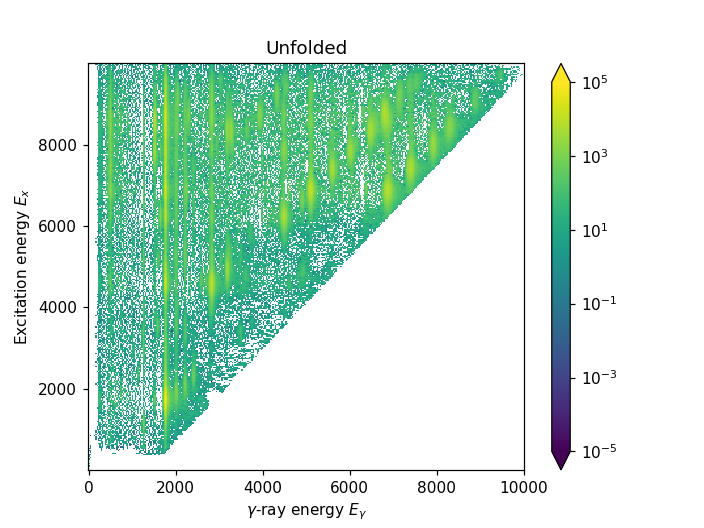

(<matplotlib.collections.QuadMesh at 0x7fb6b465bd90>,
 <Figure size 640x480 with 2 Axes>)

In [9]:
#Projecting the second excited state (4617 keV) of 28Si to the Eg axis
unfolded_OMpy_proj, E = unfolded_OMpy.projection(axis="Eg",  Emin=4400, Emax=4800)

#Plotting the OMpy unfolded raw matrix 
unfolded_OMpy.plot(vmin=10**(-5), vmax=10**(5))

In [15]:
# The unfolded fbu had ranges [0,8025] keV. Ex[258] = 8025 keV
unfolder_fbu = np.zeros((len(Ex[:258]), len(raw_py)))
#All energies under 647 keV where not unfolded since the raw matrix did not cointain counts here to unfold
# Ex[20] = 647 keV
print(Ex[20])
print(Ex[258])
print(unfolder_fbu.shape)

647.0
8025.0
150.60240963855424
(258, 333)


In [17]:
# HPD interval
HPD = np.zeros((len(Ex[:258]), len(raw_py), 2))
print(HPD.shape)

(258, 333, 2)


In [18]:
# Retrieving the unfolded of FBU with the HPD intervals for each Ex:
# The threshold was set to Eg[5] = 150 keV
thres = 5
for i in range(len(Ex[:258])):
    
    if (i >= 20):
        path = '/home/vala/Documents/Master/jupyter_notebook/28Si_unfolding_ALL/hpd_intervals/Already_finished/'
        name = 'unfolding_Si28_credint_68_%d'%Ex[i]
        df = pd.read_csv(path + name + ".csv")
        mean_temp = df.loc[:, df.columns=='est. mean'].values
        HPD_temp_min = df.loc[:, df.columns=='HPD min'].values 
        HPD_temp_max = df.loc[:, df.columns=='HPD max'].values
        
        mean_temp = np.ravel(mean_temp)
        HPD_temp_min = np.ravel(HPD_temp_min)
        HPD_temp_max = np.ravel(HPD_temp_max)

        a = np.zeros(len(raw_py[len(mean_temp)+thres:]))
        b = np.zeros(len(raw_py[:thres]))
        unfolded = np.concatenate((b,mean_temp,a))
        HPD_temp_min = np.concatenate((b,HPD_temp_min,a))
        HPD_temp_max = np.concatenate((b,HPD_temp_max,a))
        
        HPD[i, :, 0] = HPD_temp_min
        HPD[i, :, 1] = HPD_temp_max
        unfolder_fbu[i] = unfolded



In [26]:
# Presenting the values of the unfolded FBU in a matrix: 
Unfolded_fbu = om.Matrix(values=unfolder_fbu, Eg=Eg, Ex=Ex[:258])
HPD_mat_min = om.Matrix(values=HPD[:,:,0], Eg=Eg, Ex=Ex[:258])
HPD_mat_max = om.Matrix(values=HPD[:,:,1], Eg=Eg, Ex=Ex[:258])


<IPython.core.display.Javascript object>


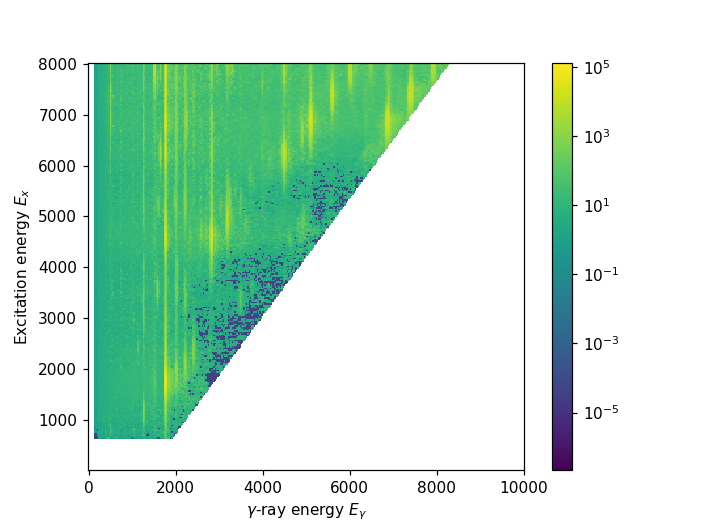

(<matplotlib.collections.QuadMesh at 0x7fb6b468ac50>,
 <Figure size 640x480 with 2 Axes>)

In [21]:
Unfolded_fbu.plot()

In [27]:
# Projecting the second excited state onto the Eg axis for the mean of the HPD interval (Unfolded_fbu),
# and the HPD interval
unfolded_fbu_proj, E = Unfolded_fbu.projection(axis="Eg",  Emin=4400, Emax=4800)
HPD_min_proj, E =  HPD_mat_min.projection(axis="Eg",  Emin=4400, Emax=4800)
HPD_max_proj, E =  HPD_mat_max.projection(axis="Eg", Emin=4400, Emax=4800)

<IPython.core.display.Javascript object>


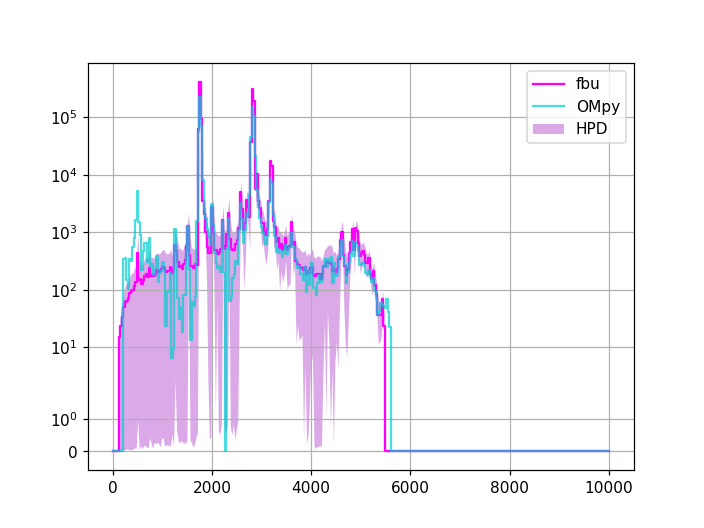

In [29]:
%matplotlib notebook

# second excited state (4617 keV) OMpy and FBU:
fig, ax = plt.subplots(1)

ax.plot(Eg, unfolded_fbu_proj, ls='steps', color= 'magenta', label=r'fbu') #, width=50, label='raw data')
ax.plot(Eg, unfolded_OMpy_proj, ls='steps', color='darkturquoise', label=r'OMpy', alpha=0.7)
ax.fill_between(Eg, (HPD_max_proj), (HPD_min_proj), facecolor='mediumorchid', alpha=0.5, label =r'HPD')
plt.legend()
plt.yscale('symlog')
plt.grid()
plt.show()